In [1]:
import pandas as pd
import numpy as np
import datetime 
import re
from urlextract import URLExtract
import spacy
import time
import pickle
import matplotlib.pyplot as plt

In [2]:
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim


### Preprocessing and document tokenization

In [3]:
# remove all urls from posts

extractor = URLExtract()
def replace_urls(x):
    urls = extractor.find_urls(x)
    if urls:
        x_new = replace_urls(x.replace(urls[0],''))
        return x_new
    else:
        return x

In [7]:
# loading our r/depression and r/anxiety data with topic labels
data_path = '/Users/collinswestnedge/programming/project_05/data'
depression = pd.read_csv(data_path+'/depression_topics.csv', low_memory=False, lineterminator='\n')
depression.drop(columns=['Unnamed: 0'], inplace=True)

anxiety = pd.read_csv(data_path+'/anxiety_topics.csv', low_memory=False, lineterminator='\n')
anxiety.drop(columns=['Unnamed: 0'], inplace=True)

depression['date'] = pd.to_datetime(depression.date)
anxiety['date'] = pd.to_datetime(anxiety.date)

# dropping a couple of nan values that made it through the preprocessing
anxiety.dropna(subset=['selftext'], inplace=True)
depression.dropna(subset=['selftext'], inplace=True)

In [178]:
# loading comments by original posters from r/anxiety and r/depression
dep_post_comments = pd.read_csv(data_path+'/author_comment_and_post_dep.csv', low_memory=False)
anx_post_comments = pd.read_csv(data_path+'/author_comment_and_post_anx.csv', low_memory=False)

In [6]:
depression['date'] = pd.to_datetime(depression.date)
anxiety['date'] = pd.to_datetime(anxiety.date)

In [ ]:
# depression[depression.text_title.str.contains(' schizophrenic ')].values[11]

In [179]:
# tokenize original posts for r/depression
dep_posts = depression.text_title
dep_tokenized_posts = [gensim.utils.simple_preprocess(p) for p in dep_posts if len(p) >= 65]

# tokenize comments by author of posts for r/depression
dep_comments = dep_post_comments[dep_post_comments.body.isna() == False].body
dep_tokenized_comments = [gensim.utils.simple_preprocess(c) for c in dep_comments if len(c) >= 65]
dep_tokenized_docs = dep_tokenized_posts+dep_tokenized_comments

In [180]:
# tokenize original posts for r/anxiety
anx_posts = anxiety.text_title
anx_tokenized_posts = [gensim.utils.simple_preprocess(p) for p in anx_posts if len(p) >= 65]

# tokenize comments by author of for r/anxiety
anx_comments = anx_post_comments[anx_post_comments.body.isna() == False].body
anx_tokenized_comments = [gensim.utils.simple_preprocess(c) for c in anx_comments if len(c) >= 65]
anx_tokenized_docs = anx_tokenized_posts+anx_tokenized_comments

In [ ]:
print('r/depression:',len(dep_tokenized_docs))
print('r/anxiety:', len(anx_tokenized_docs))

### Defining our word2vec models

In [11]:
import multiprocessing
from tqdm import tqdm
from sklearn import utils
from gensim.models.callbacks import CallbackAny2Vec

In [12]:
# defining a class to log our loss for each epoch
# note that gensim has some issues/bugs with the compute loss parameter
# so this is being used to loosely identify the elbow in our loss

class LossLogger(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''

    def __init__(self):
        self.epoch = 0
        self.loss_to_be_subed = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        loss_now = loss - self.loss_to_be_subed
        self.loss_to_be_subed = loss
        print('Loss after epoch {}: {}'.format(self.epoch, loss_now))
        self.epoch += 1
        
loss_logger = LossLogger()

# also to speed things up we will want to use all available cores
cores = multiprocessing.cpu_count()

In [13]:
# after looking at the data words that appear less than 9 times are predominantly uncommon mispellings
# so our min count for r/depression will be 9 in the 10-15 range we see less mispellings/valid uncommon words
# with r/depression data anything over 10 epochs will give good results

# r_depression_model = gensim.models.Word2Vec(
#                                             dep_tokenized_docs,
#                                             size=300,
#                                             window=5,
#                                             min_count=9,
#                                             sg=1,
#                                             callbacks=[loss_logger],
#                                             compute_loss=True,
#                                             iter=35,
#                                             workers=cores
#                                             )

In [ ]:
# r_depression_model.save("models/r_depression.model")

In [14]:
# after looking at the data words that appear less than 5 times are predominantly uncommon mispellings
# so our min count for r/anxiety will be 5 in the 7-12 range we see less mispellings/valid uncommon words
# with our r/anxiety data more epochs than r/depression are needed.

# r_anxiety_model = gensim.models.Word2Vec(
#                                          anx_tokenized_docs,
#                                          size=300,
#                                          window=5,
#                                          min_count=5,
#                                          sg=1,
#                                          callbacks=[loss_logger],
#                                          compute_loss=True,
#                                          iter=45,
#                                          workers=cores
#                                         )

In [ ]:
# r_anxiety_model.save("models/r_anxiety.model")

In [15]:
model_path = '/Users/collinswestnedge/programming/project_05/models'
r_anxiety_model = gensim.models.Word2Vec.load(model_path+"/r_anxiety.model")
r_depression_model = gensim.models.Word2Vec.load(model_path+"/r_depression.model")

### Examining the learned word embeddings for our models

In [ ]:
r_depression_model.wv.most_similar(['scared'], topn=10)

In [ ]:
r_depression_model.wv.most_similar(['bored'], topn=10)

In [ ]:
r_depression_model.wv.most_similar(['love'], topn=10)

In [ ]:
# anxiety[anxiety.selftext.str.contains(' reddit ')].values[2]

In [ ]:
r_depression_model.wv.most_similar(positive=['social', 'media', 'account'], topn=10)

In [ ]:
r_depression_model.wv.most_similar(['motivation'], topn=30)

In [ ]:
r_depression_model.wv.most_similar(['hate'], topn=30)

In [ ]:
r_anxiety_model.wv.most_similar(positive=['psychiatrist'], negative=['prescribed'], topn=20)

In [ ]:
r_depression_model.wv.most_similar(positive=['psychiatrist'], negative=['prescribed'], topn=20)

In [ ]:
r_depression_model.wv.most_similar(positive=['comment'], topn=10)

In [ ]:
r_anxiety_model.wv.most_similar(positive=['comment'], topn=10)

In [ ]:
r_depression_model.wv.most_similar(positive=['boy', 'woman'], negative=['man'],topn=10)

In [37]:
a = r_depression_model.wv.most_similar(positive=['boy', 'talks'], negative=['girl'],topn=10)
c = list(zip(*a))
c[0]

('speaks',
 'says',
 'cries',
 'asks',
 'tells',
 'talk',
 'sees',
 'complains',
 'calls',
 'listens')

In [64]:
def get_most_similar_dep(subreddit, pos, neg, num_words=10):
    if subreddit == 'depression':
        results = r_depression_model.wv.most_similar(positive=pos, negative=neg,topn=num_words)
        words = list(zip(*results))
        return words[0]
    else:
        results = r_anxiety_model.wv.most_similar(positive=pos, negative=neg,topn=num_words)
        words = list(zip(*results))
        return words[0]

In [ ]:
dep_tokenized_docs[0:3]

In [223]:
words = ['talks','thinks','believes', 'exercises', 'creep', 'creepy', 'lesbian', 'gives', 'stalks']

for word in words:
    temp = get_most_similar_dep('depression', pos=['boy', word], neg=['girl'], num_words=50)
    print('boy + {} - girl: \n{}'.format(word, temp))
    print()

boy + talks - girl: 
('speaks', 'says', 'cries', 'asks', 'tells', 'talk', 'sees', 'complains', 'calls', 'listens', 'treats', 'tries', 'uses', 'acts', 'yells', 'hears', 'ronald', 'pretends', 'talkes', 'finds', 'screams', 'learns', 'thinks', 'laughs', 'whines', 'talked', 'buys', 'pesters', 'knows', 'deals', 'berates', 'compares', 'chooses', 'brags', 'talking', 'defends', 'cares', 'rants', 'mentions', 'watches', 'gets', 'blasts', 'abuses', 'weaves', 'belittles', 'complain', 'stares', 'son', 'manages', 'manipulates')

boy + thinks - girl: 
('says', 'believes', 'tells', 'assumes', 'sees', 'knows', 'think', 'insists', 'hates', 'acts', 'treats', 'apparently', 'uses', 'son', 'finds', 'assume', 'blames', 'considers', 'pretends', 'expects', 'claims', 'mommas', 'suspects', 'deals', 'ronald', 'according', 'overreacting', 'said', 'daughter', 'plays', 'gaslights', 'complains', 'loves', 'argues', 'tries', 'wants', 'yes', 'chooses', 'disgraceful', 'decides', 'learns', 'whimp', 'lazy', 'needs', 'brothe

In [165]:
words = ['talks','butt', 'wants', 'workout', 'believes', 'medication']

gendered_data = []
for word in words:
    temp = get_most_similar_dep('depression', pos=['woman', word], neg=['men'], num_words=50)
    operation = 'man - woman + {}'.format(word)
    search_term = 'man woman ' + word
    synonyms = ' '.join([item for item in temp])
    gendered_data.append([operation, search_term, synonyms])


In [167]:
gendered_df = pd.DataFrame(gendered_data)
gendered_df.columns = ['operation', 'search_term', 'synonyms']
gendered_df

,operation,search_term,synonyms
0,man - woman + talks,man woman talks,speaks cares spoke talked talk loves wants see...
1,man - woman + butt,man woman butt,ass arse girl guy sweetest feisty boy nerve la...
2,man - woman + wants,man woman wants,loves likes refuses decides thinks needs cares...
3,man - woman + workout,man woman workout,exercise gym exercising diet routine exercised...
4,man - woman + believes,man woman believes,thinks believe believed loves knows sees wants...
5,man - woman + medication,man woman medication,meds antidepressant medicine depressant antide...


In [191]:
depression.text_title.iloc[0:3]

0    just got dismissed from my university i had a ...
1    im a spoiled piece of shit im on a vacation wi...
2    caring about a person that doesn't i'm a 17 ye...
Name: text_title, dtype: object

In [202]:
# import spacy
# from spacy.lang.en.stop_words import STOP_WORDS

# nlp = spacy.load("en")

# def process_text(nlp, text, pos_list, lemma=False):

#     text_full = [] 
#     for doc in nlp.pipe(text, disable=['ner', 'parser']):
#         # if part of speech list isnt empty return matches for pos
#         if pos_list:
#             tokens = [(ent.text) for ent in doc if not ent.is_punct and not ent.is_stop and ent.pos_ in pos_list]
#             cleaned_text = " ".join(tokens)
#             text_full.append(cleaned_text)
#         elif lemma == True:
#             tokens = [(ent.lemma_) for ent in doc if not ent.is_stop and not ent.is_punct]
#             cleaned_text = " ".join(tokens)
#             text_full.append(cleaned_text)
#         else:
#             tokens = [(ent.text) for ent in doc if not ent.is_stop and not ent.is_punct]
#             cleaned_text = " ".join(tokens)
#             text_full.append(cleaned_text)
            
#     return text_full

# corp = depression.text_title
# # corp = useable_text.text_title
# only_verbs = process_text(nlp, corp, pos_list=['VERB'], lemma=False)
# len(only_verbs)

In [173]:
list(gendered_df[gendered_df.search_term == 'man woman talks']['synonyms'])

['speaks cares spoke talked talk loves wants sees acknowledges tells likes listens complains asks says misses writes tries thinks finds perosn knows talking calls cries speak spoken remembers girl gives manages responds fancies she person hates talkes guy cared buys reaches greets yells hoot sends hears reads pretends interacts girlfriend']

sideffects (insomnia libido), prescriptions(adderall, antidepressant/ssri)

gender = king - queen , gender = man - woman

king - x = man - woman
man - woma - king = - x
woman - man + king = x

man + royal = king
woman + royal = queen



In [ ]:
r_depression_model.wv.most_similar(positive=['effects'],topn=20)

In [ ]:
r_depression_model.wv.most_similar(positive=['appetite'],topn=40)

In [ ]:
r_depression_model.wv.most_similar(positive=['appetite', 'antidepressants'], negative=['stimulants'],topn=20)

In [ ]:
r_depression_model.wv.most_similar(positive=['appetite', 'ssris'], negative=['stimulants'],topn=20)

In [ ]:
# diff = model1.wv['libido'] + model1.wv['antidepressant']
# model2.wv.most_similar(['girl'],topn=100)

In [ ]:
# diff = model.wv['stimulants'] - model.wv['anxiety'] + model.wv['antidepressants']
# model.wv.similar_by_vector(diff,topn=40)
# model2.wv.most_similar(positive=['appetite', 'zoloft'], negative=['adderall'], topn=40)

In [ ]:
# sanity check
print(r_depression_model.wv.most_similar(positive=['guy', 'woman'], negative=['girl'], topn=10))
print()
print(r_depression_model.wv.most_similar(positive=['bad', 'happy'], negative=['good'], topn=10))
# print(model2.wv.most_similar(positive=['yeezy', 'obama'], negative=['japan'], topn=20))


In [ ]:
print(r_depression_model.wv.most_similar(positive=['manga', 'america'], negative=['japan'], topn=20))
print()
print(r_depression_model.wv.most_similar(positive=['anime', 'america'], negative=['japan'], topn=20))

In [ ]:
print(r_anxiety_model.wv.most_similar(positive=['manga', 'america'], negative=['japan'], topn=20))
print()
print(r_anxiety_model.wv.most_similar(positive=['anime', 'america'], negative=['japan'], topn=20))

In [ ]:
wt = r_depression_model.wv.most_similar(positive=['man', 'talks'], negative=['woman'], topn=30)
mt = r_depression_model.wv.most_similar(positive=['woman', 'talks'], negative=['man'], topn=20)
mt

In [ ]:
wt = r_depression_model.wv.most_similar(positive=['guy', 'talks'], negative=['girl'], topn=20)
mt = r_depression_model.wv.most_similar(positive=['guy', 'talks'], negative=['girl'], topn=20)
wt

In [ ]:
r_depression_model.wv.most_similar(positive=['dog', 'barks'], negative=['cat'],topn=30)

In [ ]:
r_depression_model.wv.most_similar(positive=['girl', 'engineer'], negative=['guy'],topn=30)

In [ ]:
# print(model2.wv.most_similar(positive=['man', 'gives'], negative=['woman'], topn=10))
wt = r_anxiety_model.wv.most_similar(positive=['man', 'talks'], negative=['woman'], topn=20)
mt = r_anxiety_model.wv.most_similar(positive=['woman', 'talks'], negative=['man'], topn=20)
mt

In [ ]:
print(r_anxiety_model.wv.most_similar(positive=['guy', 'gives'], negative=['girl'], topn=20))
print()
print(r_anxiety_model.wv.most_similar(positive=['guy', 'gives'], negative=['girl'], topn=20))

In [ ]:
print(r_depression_model.wv.most_similar(positive=['guy', 'gives'], negative=['girl'], topn=20))
print()
print(r_depression_model.wv.most_similar(positive=['girl', 'gives'], negative=['guy'], topn=20))

In [ ]:
print(r_depression_model.wv.most_similar(positive=['guy', 'talks'], negative=['girl'], topn=15))


In [ ]:
print(r_depression_model.wv.most_similar(positive=['guy', 'asks'], negative=['girl'], topn=15))


In [ ]:
# wt = r_depression_model.wv.most_similar(positive=['guy', 'talks'], negative=['girl'], topn=12)
# mt = r_anxiety_model.wv.most_similar(positive=['guy', 'talks'], negative=['girl'], topn=12)

wt = r_depression_model.wv.most_similar(positive=['anime', 'america'], negative=['japan'], topn=12)
mt = r_anxiety_model.wv.most_similar(positive=['anime', 'america'], negative=['japan'], topn=12)

funny_list = [[item[0], round(item[1], 4)] for item in mt]
funny_list2 = [[item[0], round(item[1], 4)] for item in wt]


x = [item[0] for item in funny_list]
y = [item[1] for item in funny_list]

x2 = [item[0] for item in funny_list2]
y2 = [item[1] for item in funny_list2]

plt.figure(figsize=[10, 7])

fig, ax = plt.subplots(figsize=[10, 8])
plt.title('Man - Woman + Talks\n', color='black', fontsize=13)
ax.barh(x, y, color = 'salmon')
plt.xlabel('Cosine Similarity', fontsize=12, color='black', fontname='Osaka')
plt.grid(False)
# plt.xlim([.24, .42])
ax.axes.tick_params(axis="y", colors='black', labelsize=12)
ax.axes.tick_params(axis="x", colors="black", labelsize=12)


plt.figure(figsize=[10, 7])

fig, ax = plt.subplots(figsize=[10, 8])
plt.title('Man - Woman + Talks\n', color='black', fontsize=13)
ax.barh(x2, y2, color = 'salmon')
plt.xlabel('Cosine Similarity', fontsize=12, color='black', fontname='Osaka')
plt.grid(False)
# plt.xlim([.24, .42])
ax.axes.tick_params(axis="y", colors='black', labelsize=12)
ax.axes.tick_params(axis="x", colors="black", labelsize=12)
# plt.savefig('MARKIPLIER.png', transparent=True, dpi=300)

In [ ]:
r_depression_model.wv.most_similar(['energy'], topn=20)

In [ ]:
r_depression_model.wv.most_similar(['insomnia'], topn=30)

In [ ]:
r_depression_model.wv.most_similar(['circadian'], topn=30)

In [ ]:
r_anxiety_model.wv.most_similar(['circadian'], topn=30)

In [ ]:
r_depression_model.wv.most_similar(positive=['sleep'], negative=['insomnia'], topn=20)

In [ ]:
# model.wv.similar_by_vector(negative=['psychiatrist', 'prescribed'],topn=20)
# model2.wv.most_similar(positive=['psychiatrist'], negative=['prescribed'], topn=20)
# model2.wv.most_similar(positive=['addict'], negative=['drugs'], topn=20)
r_depression_model.wv.most_similar(positive=['alcoholic'], negative=['alcohol'], topn=20)



In [ ]:
r_depression_model.wv.most_similar(positive=['alcoholic'], topn=20)


In [ ]:
r_anxiety_model.wv.most_similar(positive=['alcoholic'], negative=['alcohol'], topn=20)


In [ ]:
# r_depression_model.wv.most_similar(positive=['sad', 'happy'], negative=['tears'], topn=20)

In [ ]:
print(r_anxiety_model.wv.most_similar(positive=['alcoholic'], topn=20))
print()
print(r_anxiety_model.wv.most_similar(positive=['addict'], negative=['drugs'], topn=20))

In [ ]:
print(r_depression_model.wv.most_similar(positive=['alcoholic'], topn=20))
print()
print(r_depression_model.wv.most_similar(positive=['addict'], negative=['drugs'], topn=20))

In [ ]:
# doc_model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)
# doc_model

In [ ]:
# import seaborn as sns

# sns.set_theme(style="whitegrid")
# a = r_depression_model.wv['man']
# b = r_depression_model.wv['woman']

# c = r_depression_model.wv['asked']
# d = r_depression_model.wv['told']



# # a = np.array([-1,1])
# # b = np.array([1,1])
# x = a + c - b

# x2 = r_depression_model.wv['therapist']
# x3 = r_depression_model.wv.similar_by_vector(x)

# # fig = plt.figure(figsize=[15,15])
# # ax = ax.gca(projection='3d')
# fig, ax = plt.subplots(figsize=[10, 8])
# V = np.array([a, b])
# origin = np.array([[0, 0],[0, 0]]) # origin point

# ax.quiver(*origin, V[:,0], V[:,1], color=['r','b','g'], scale=1.2)
# # plt.xlim([-.002, .002])
# # plt.show()
# # model.wv.similar_by_vector(x)

# ax.axes.tick_params(axis="y", colors='white', labelsize=10)
# ax.axes.tick_params(axis="x", colors="white", labelsize=10)
# plt.grid(False)
# # plt.savefig('vecs11.png', transparent=True, dpi=300)


In [ ]:
# from gensim.models.doc2vec import Doc2Vec, TaggedDocument
# from nltk.tokenize import word_tokenize

# text = data_copy.text_title
# tokenized_self_text = [gensim.utils.simple_preprocess(d) for d in text]

# author = data_copy.author
# tokenized_title = [gensim.utils.simple_preprocess(d) for d in author]


# tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(data)]
# tagged_data[1:10]

In [ ]:
# docs = []
# for index, doc in enumerate(tokenized_self_text):
#     tagged = TaggedDocument(words=doc, tags=[index])
#     docs.append(tagged)

In [ ]:
# # define parameters for doc2vec
# doc_model = gensim.models.Doc2Vec(
#                                   vector_size=300,
#                                   window=5,
#                                   min_count=5,
#                                   workers=cores,
#                                   epochs=10,
#                                   alpha=.025,
#                                   min_alpha = 0.0001)
# doc_model.build_vocab(docs)

In [ ]:
# train model
# doc_model.train(docs, total_examples=doc_model.corpus_count, epochs=doc_model.epochs)

In [ ]:
# a = '''
# Slowly isolating myself
# Sorry just wanted to say something to anyone really
# but i used to talk to a couple people about my issues
# and how i was doing but i feel like everytime i do i
# annoy them and that im being boring or just a pain to be around.
# I always overthink situations and im probably doing the same here but
# im sat here just wishing i could talk to those i trust but i
# also dont want to be a burden all the time. I cant talk to many people
# and i struggle to talk to new people. Also there some of my best friends
# i dont want to lose them but i also know i need to express how I feel.
# Thank you for reading my rambling if you did..
# '''

In [ ]:
# testing = gensim.utils.simple_preprocess(a)

In [ ]:
# inferred_vector = doc_model.infer_vector(testing)
# sims = doc_model.docvecs.most_similar([inferred_vector], topn=len(doc_model.docvecs))
# sims[:10]

In [ ]:
# testing = '''
# i really need advice on my medication i just starting taking zoloft'''

# testing = gensim.utils.simple_preprocess(testing)
# testing

In [ ]:
# vec_df = pd.DataFrame(doc_model.docvecs.vectors_docs)

In [ ]:
# doc_model.docvecs.vectors_docs.shape

### Saving our word embeddings to a tensorflow friendly format so we can load embeddings into embedding projector

In [ ]:

# words = []
# counts =[]
# w2v = gensim.models.Word2Vec.load("models/r_anxiety.model")
# for index in range(len(w2v.wv.index2word)):
#     word = w2v.wv.index2word[index]
#     words.append(word)
#     counts.append(w2v.wv.vocab[word].count)
    
# pd.DataFrame({'word':words, 'count':counts}).to_csv('/Users/collinswestnedge/programming/project_05/tensor_data/anxiety/r_anxiety_meta.tsv', index=False,sep='\t' )

# import io

# path2 = '/Users/collinswestnedge/programming/project_05/tensor_data/anxiety/r_anxiety_'

# out_v = io.open(path2+'vecs.tsv', 'w', encoding='utf-8')

# # Write meta file and vector file
# for index in range(len(w2v.wv.index2word)):
#     word = w2v.wv.index2word[index]
#     vec = w2v.wv.vectors[index]
#     count = w2v.wv.vocab[word].count
# #     out_m.write(word + "\n")
#     out_v.write('\t'.join([str(x) for x in vec]) + "\n")
# out_v.close()
# # out_m.close()

In [ ]:
# from collections import defaultdict

# unique_words = defaultdict(int)

# for index in range(len(w2v.wv.index2word)):
#     word = w2v.wv.index2word[index]
#     unique_words[w2v.wv.index2word[index]] = w2v.wv.vocab[word].count

### Comparing word co-occurrences/ngrams for schizophrenic and alcoholic

In [7]:
dep_post_comments['body'] = dep_post_comments.body.str.lower()
depression['text_title'] = depression.text_title.str.lower()

In [1068]:
comments_schizophrenic = (dep_post_comments[(dep_post_comments.body.isna() == False)&
                                            (dep_post_comments.body.str.contains('schizophrenic'))]
                          .body)

posts_schizophrenic = (depression[(depression.text_title.isna() == False)&
                                            (depression.text_title.str.contains('schizophrenic'))]
                       .text_title)


comments_autistic = (dep_post_comments[(dep_post_comments.body.isna() == False)&
                                            (dep_post_comments.body.str.contains('autistic'))]
                          .body)

posts_autistic = (depression[(depression.text_title.isna() == False)&
                                            (depression.text_title.str.contains('autistic'))]
                       .text_title)

comments_alcoholic = (dep_post_comments[(dep_post_comments.body.isna() == False)&
                                            (dep_post_comments.body.str.contains('alcoholic'))]
                          .body)

posts_alcoholic = (depression[(depression.text_title.isna() == False)&
                                            (depression.text_title.str.contains('alcoholic'))]
                       .text_title)

comments_psychotic = (dep_post_comments[(dep_post_comments.body.isna() == False)&
                                            (dep_post_comments.body.str.contains('psychotic'))]
                          .body)

posts_psychotic = (depression[(depression.text_title.isna() == False)&
                                            (depression.text_title.str.contains('psychotic'))]
                       .text_title)


comments_addict = (dep_post_comments[(dep_post_comments.body.isna() == False)&
                                            (dep_post_comments.body.str.contains('addict'))]
                          .body)

posts_addict = (depression[(depression.text_title.isna() == False)&
                                            (depression.text_title.str.contains('addict'))]
                       .text_title)

In [1069]:
schizophrenic_full = pd.concat([posts_schizophrenic,comments_schizophrenic])
autistic_full = pd.concat([comments_autistic, posts_autistic])
alcoholic_full = pd.concat([comments_alcoholic, posts_alcoholic])
psychotic_full = pd.concat([comments_psychotic, posts_psychotic])
addict_full = pd.concat([posts_addict, comments_addict])

In [1070]:
from nltk.util import ngrams

list(ngrams('hey i love you'.split(), 4))

[('hey', 'i', 'love', 'you')]

In [1210]:
import re
from collections import defaultdict
from nltk.util import ngrams
import itertools
import collections

nlp = spacy.load("en")
def process_text2(nlp, text, pos_list, lemma=False):

    text_full = [] 
    for doc in nlp.pipe(text, disable=['parser', 'ner']):
        
        if pos_list:
            tokens = [(ent.text) for ent in doc if not ent.is_stop and ent.pos_ in pos_list]
            cleaned_text = " ".join(tokens)
            text_full.append(cleaned_text)
        else:
        # if part of speech list isnt empty return matches for pos
            tokens = [(ent.text) for ent in doc if not ent.is_stop]
            cleaned_text = " ".join(tokens)
            text_full.append(cleaned_text)

    return text_full


text = process_text2(nlp, schizophrenic_full, ['NOUN', 'ADJ','VERB', 'PUNCT', 'ADV'])
text = ' '.join(text)
sent = text.split('.')
sent_clean = [re.sub(r'\W+', ' ', item.strip()).split() for item in sent if item!="" and 'schizophrenic' in item]
sent_clean


text2 = process_text2(nlp, alcoholic_full, ['NOUN', 'ADJ', 'VERB', 'PUNCT', 'ADV'])
text2 = ' '.join(text2)
sent2 = text2.split('.')
sent_clean2 = [re.sub(r'\W+', ' ', item.strip()).split() for item in sent2 if item!="" and 'alcoholic' in item]

# text = process_text2(nlp, schizophrenic_full, [])
# text = ' '.join(text)
# sent = text.split('.')
# sent_clean = [re.sub(r'\W+', ' ', item.strip()).split() for item in sent if item!="" and 'schizophrenic' in item]
# sent_clean


# text2 = process_text2(nlp, alcoholic_full, [])
# text2 = ' '.join(text2)
# sent2 = text2.split('.')
# sent_clean2 = [re.sub(r'\W+', ' ', item.strip()).split() for item in sent2 if item!="" and 'alcoholic' in item]


In [1212]:
vocab_schizophrenic = defaultdict(int)
vocab_alcoholic = defaultdict(int)

for sent in sent_clean:
    for word in sent:
        vocab_schizophrenic[word]+=1
        
for sent in sent_clean2:
    for word in sent:
        vocab_alcoholic[word]+=1

In [1317]:
def get_ngrams(cleaned_text, ngrams_num=2, top_n=20, word=None):
    ngrams_docs = [list(ngrams(doc, ngrams_num)) for doc in cleaned_text]
    word_ngrams = []
    if word: 
        for doc in ngrams_docs:
            for ngram in doc:
                if word in list(ngram):
                    word_ngrams.append(ngram)
    else:
        for doc in ngrams_docs:
            for ngram in doc:
                word_ngrams.append(ngram)
    
    if not top_n:
        return word_ngrams
    else:
        ngram_counts = collections.Counter(word_ngrams)
        return ngram_counts.most_common(top_n)

ngrams_schizophrenic = get_ngrams(sent_clean, ngrams_num=2, top_n=None, word='schizophrenic')
ngrams_alcoholic = get_ngrams(sent_clean2, ngrams_num=2, top_n=None, word='alcoholic')

In [1318]:
len(ngrams_schizophrenic)

656

In [1319]:
alcoholic_bigrams = defaultdict(int)
for ngram in ngrams_alcoholic:
    term = 'alcoholic'
    if term in list(ngram):
        new_term = tuple(' '.join(ngram).replace(term, 'x').split())
        alcoholic_bigrams[new_term]+=1
        
        
schizophrenic_bigrams = defaultdict(int)
for ngram in ngrams_schizophrenic:
    term = 'schizophrenic'
    if term in list(ngram):
        new_term = tuple(' '.join(ngram).replace(term, 'x').split())
        schizophrenic_bigrams[new_term]+=1

In [1262]:
# remove schizophrenic and alcoholic from trigrams so we can 
# compare the words that surround these words and see where they overlap

# alcoholic_bigrams = defaultdict(int)
# for ngram in ngrams_alcoholic:
#     term = 'alcoholic'
#     temp = list(ngram)
#     if term in temp:
        
#         temp.remove(term)
#     alcoholic_bigrams[tuple(sorted(temp))]+=1
    
    
# schizophrenic_bigrams = defaultdict(int)
# for ngram in ngrams_schizophrenic:
#     term = 'schizophrenic'
#     temp = list(ngram)
#     if term in temp: 
#         temp.remove(term)
#     schizophrenic_bigrams[tuple(sorted(temp))]+=1

In [1322]:

schizophrenic_ngram_counts = collections.Counter(schizophrenic_bigrams)
top_schiz = schizophrenic_ngram_counts.most_common(120)

alcoholic_ngram_counts = collections.Counter(alcoholic_bigrams)
top_alc = alcoholic_ngram_counts.most_common(120)

In [1323]:
# top_schiz

In [1324]:
a = set([item[0] for item in top_alc])
b = set([item[0] for item in top_schiz])
top_bigram_intersect = a.intersection(b)

target_words = []
for bigram in top_bigram_intersect:
    for word in bigram:
        if word not in target_words:
            target_words.append(word)
        
len(target_words)
top_bigram_intersect

{('abusive', 'x'),
 ('brother', 'x'),
 ('dad', 'x'),
 ('dads', 'x'),
 ('depressed', 'x'),
 ('depression', 'x'),
 ('father', 'x'),
 ('know', 'x'),
 ('live', 'x'),
 ('m', 'x'),
 ('mom', 'x'),
 ('mother', 'x'),
 ('parents', 'x'),
 ('probably', 'x'),
 ('sister', 'x'),
 ('think', 'x'),
 ('time', 'x'),
 ('turn', 'x'),
 ('x', 'bipolar'),
 ('x', 'brother'),
 ('x', 'dad'),
 ('x', 'depressed'),
 ('x', 'drug'),
 ('x', 'father'),
 ('x', 'feel'),
 ('x', 'husband'),
 ('x', 'know'),
 ('x', 'life'),
 ('x', 'mom'),
 ('x', 'mother'),
 ('x', 'physically'),
 ('x', 'probably'),
 ('x', 'sister'),
 ('x', 'time'),
 ('x', 'violent'),
 ('x', 'way')}

In [1325]:
for idx, doc in enumerate(sent_clean):
    if 'abusive' in doc:
        print(doc, idx)

['abusive', 'schizophrenic', 'brother'] 79
['mother', 'schizophrenic', 'physically', 'abusive'] 105
['emotionally', 'abusive', 'respect', 'mental', 'health', 'called', 'schizophrenic', 'whore', 'think', 'lying', 'problems', 'people', 'sensory', 'overload', 'people', 'family'] 131
['years', 'abusive', 'friendship', 'girl', 'ended', 'completely', 'fucking', 'mom', 'schizophrenic', 'mental', 'problems'] 142
['diagnosed', 'shitty', 'abusive', 'stepdad', 'schizophrenic', 'dad', 'self', 'imolated'] 178
['sister', 'borderline', 'abusive', 'schizophrenic', 'sister', 'younger', 'kept', 'saying', 'thought', 'dad', 'wanted', 'family', 'time', 'thinking', 'night', 'going', 'note', 'told', 'confronted'] 279
['dad', 'literally', 'sacrificed', 'entire', 'life', 'care', 'schizophrenic', 'abusive', 'mother'] 315


In [1294]:
a = set(list(alcoholic_bigrams))
b = set(list(schizophrenic_bigrams))
top_bigram_intersect2 = a.intersection(b)

target_words = []
for bigram in top_bigram_intersect2:
    for word in bigram:
        if word not in target_words:
            target_words.append(word)
        
target_words_test = list(set(target_words))

In [1295]:
top_bigram_intersect2

{('anxiety', 'attacks', 'x'),
 ('bi', 'polar', 'x'),
 ('dad', 'x', 'violent'),
 ('depression', 'anxiety', 'x'),
 ('family', 'members', 'x'),
 ('grew', 'x', 'father'),
 ('issues', 'mother', 'x'),
 ('live', 'x', 'father'),
 ('living', 'x', 'mother'),
 ('major', 'depression', 'x'),
 ('mentally', 'ill', 'x'),
 ('mom', 'x', 'dad'),
 ('mom', 'x', 'father'),
 ('mom', 'x', 'life'),
 ('older', 'brother', 'x'),
 ('people', 'calling', 'x'),
 ('x', 'abusive', 'mother'),
 ('x', 'bipolar', 'father'),
 ('x', 'childhood', 'memories'),
 ('x', 'drug', 'user'),
 ('x', 'know', 'help'),
 ('x', 'mother', 'father'),
 ('x', 'mother', 'told'),
 ('x', 'physically', 'abusive'),
 ('x', 'year', 'old')}

In [1269]:
# alcoholic_context_terms = []
# for ngram in ngrams_alcoholic:
#     for word in list(ngram[0]):
#         if word !='alcoholic':
#             alcoholic_context_terms.append(word)
            
# schizophrenic_context_terms = []
# for ngram in ngrams_schizophrenic:
#     for word in list(ngram[0]):
#         if word !='schizophrenic':
#             schizophrenic_context_terms.append(word)
            
            
# schizo_alcoholic_terms = set(schizophrenic_context_terms+alcoholic_context_terms)
# target_words = list(schizo_alcoholic_terms)
# len(target_words)

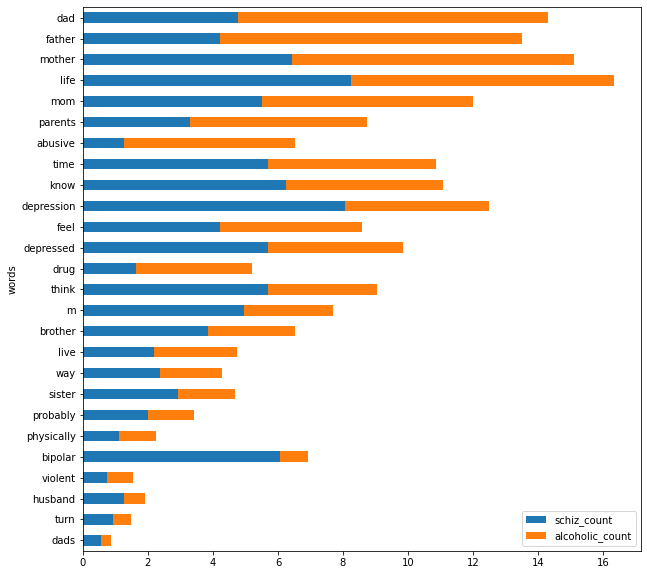

In [1326]:
bigram_data = ({'words':target_words,
                'schiz_count':[vocab_schizophrenic[word] for word in target_words],
                'alcoholic_count':[vocab_alcoholic[word] for word in target_words]})

bigram_df = pd.DataFrame(bigram_data)
bigram_df['schiz_count'] = (bigram_df.schiz_count / bigram_df.schiz_count.sum())*100
bigram_df['alcoholic_count'] = (bigram_df.alcoholic_count / bigram_df.alcoholic_count.sum())*100
bigram_df['diff'] = abs(bigram_df.alcoholic_count - bigram_df.schiz_count)

bigram_df.index = bigram_df.words
(bigram_df.sort_values(by=['alcoholic_count'], ascending=True)[['schiz_count', 'alcoholic_count']].tail(26)
 .plot.barh(figsize=[10,10], stacked=True));


In [1327]:
all_sent = sent_clean + sent_clean2

In [1328]:
word_cnt = defaultdict(int)
for words in all_sent:
    for word in words:
        word_cnt[word] += 1
    
word_cnt_df = pd.DataFrame({'word': [k for k in word_cnt.keys()], 'cnt': [v for v in word_cnt.values()]})
len(word_cnt_df)

5333

In [1329]:
target_words.remove('x')

In [1330]:
vocab = {}
for word in target_words:
    if word not in vocab:
        vocab[word] = len(vocab)

re_vocab = {}
for word, i in vocab.items():
    re_vocab[i] = word
    

In [1331]:
# len(word_comb_flat.intersection(word_comb2_flat))

In [1346]:
from scipy.spatial import distance

word_combinations = [list(itertools.combinations(words, 2)) for words in sent_clean]
word_combinations2 = [list(itertools.combinations(words, 2)) for words in sent_clean2]
word_comb_full = word_combinations + word_combinations2
combination_matrix = np.zeros((len(vocab), len(vocab)))

for word_comb in word_combinations:
    for comb in word_comb:
        if comb[0] in target_words and comb[1] in target_words:
            combination_matrix[vocab[comb[0]], vocab[comb[1]]] += 1
            combination_matrix[vocab[comb[1]], vocab[comb[0]]] += 1
        
for i in range(len(vocab)):
    combination_matrix[i, i] /= 2
        
combination_matrix
        
# combination_matrix.shape

jaccard_matrix = 1 - distance.cdist(combination_matrix, combination_matrix, 'cosine')
jaccard_matrix.shape

(26, 26)

In [1347]:
nodes = []

for i in range(len(vocab)):
    for j in range(i+1, len(vocab)):
        jaccard = jaccard_matrix[i, j]
        if jaccard > 0:
            nodes.append([re_vocab[i], re_vocab[j], word_cnt[re_vocab[i]], word_cnt[re_vocab[j]], jaccard])
            
len(nodes)

325

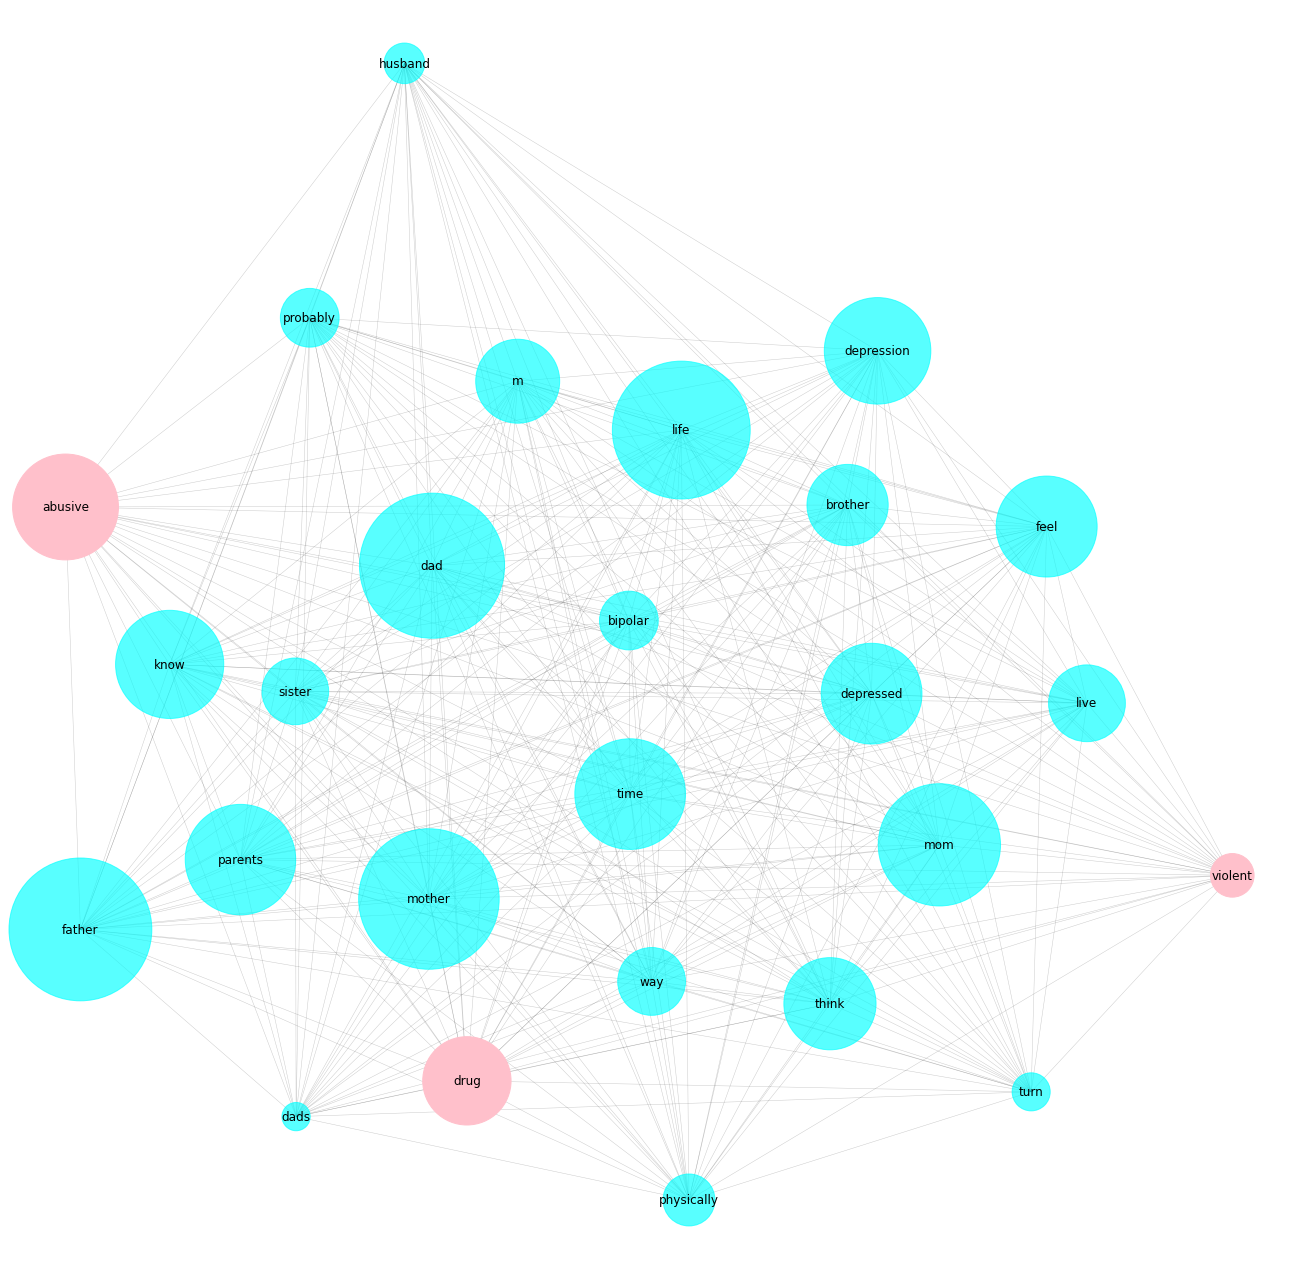

In [1348]:
import networkx as nx

G = nx.Graph()
G.nodes(data=True)

for pair in nodes:
    node_x, node_y, node_x_cnt, node_y_cnt, jaccard = pair[0], pair[1], pair[2], pair[3], pair[4]
    if not G.has_node(node_x):
        G.add_node(node_x, count=node_x_cnt)
    if not G.has_node(node_y):
        G.add_node(node_y, count=node_y_cnt)
    if not G.has_edge(node_x, node_y):
        G.add_edge(node_x, node_y, weight=jaccard)
        
plt.figure(figsize=(23,23))
pos = nx.spring_layout(G, k=0.1)

pejorative = ['abuse', 'abusive', 'violent', 'drug','abusive',
              'homicidal', 'scared', 'cheater',
              'delusional', 'criminal', 'shame', 'mad', 'unemployed', 'addict']
# pejorative = ['bipolar']

node_size = [d['count']*10 if n not in pejorative else 5000 for (n,d) in G.nodes(data=True)]
node_size = [d['count']*50 for (n,d) in G.nodes(data=True)]
pink = (255/255,192/255,203/255,1.0)

colors = [(0.0,1.0,1.0, .65) if n not in pejorative else pink for (n,d) in G.nodes(data=True)]
nx.draw_networkx_nodes(G, pos, 
                       node_color=colors,
#                        alpha=.75,
                       node_size=node_size)
nx.draw_networkx_labels(G, pos)

edge_width = [d['weight']*10 for (u,v,d) in G.edges(data=True)]
# G.add_node("cheater", count=300)

nx.draw_networkx_edges(G, pos, alpha=0.2, edge_color='black', width=.5)

plt.axis('off')
plt.show()

In [ ]:
# node_size = [d['count']*200 for (n,d) in G.nodes(data=True)]
# colors = ['cyan' if n not in pejorative else 'red' for (n,d) in G.nodes(data=True)]

In [1316]:
# import networkx as nx

# # bigrams_schiz = get_bigrams('schizophrenic', processed_text_schizophrenic, top_n = 60)
# bigram_df = pd.DataFrame(bigrams_full, columns=['bigram', 'count'])
# bigram_df

# bigram_dict = bigram_df.set_index('bigram').T.to_dict('records')

# G = nx.Graph()

# # Create connections between nodes
# for k, v in bigram_dict[0].items():
#     G.add_edge(k[0], k[1], weight=(v * 10))

# G.add_node("schizophrenic", weight=100)


# fig, ax = plt.subplots(figsize=(20, 20))

# pos = nx.spring_layout(G, k=2)

# # Plot networks
# nx.draw_networkx(G, pos,
#                  font_size=16,
#                  width=3,
#                  edge_color='grey',
#                  node_color='purple',
#                  with_labels = False,
#                  ax=ax)

# # Create offset labels
# for key, value in pos.items():
#     x, y = value[0]+.135, value[1]+.045
#     ax.text(x, y,
#             s=key,
#             bbox=dict(facecolor='red', alpha=0.25),
#             horizontalalignment='center', fontsize=13)
    
# plt.show()